/Users/Vincent/opt/anaconda3/envs/py38/lib/python3.8/site-packages/astropy/convolution/kernels.py:97: RuntimeWarning: divide by zero encountered in double_scalars
  self._model = models.Gaussian1D(1.0 / (np.sqrt(2 * np.pi) * stddev), 0, stddev)
/Users/Vincent/opt/anaconda3/envs/py38/lib/python3.8/site-packages/astropy/modeling/functional_models.py:213: RuntimeWarning: divide by zero encountered in divide
  return amplitude * np.exp(-0.5 * (x - mean) ** 2 / stddev**2)
/Users/Vincent/opt/anaconda3/envs/py38/lib/python3.8/site-packages/astropy/modeling/functional_models.py:213: RuntimeWarning: invalid value encountered in divide
  return amplitude * np.exp(-0.5 * (x - mean) ** 2 / stddev**2)
/Users/Vincent/opt/anaconda3/envs/py38/lib/python3.8/site-packages/astropy/modeling/functional_models.py:213: RuntimeWarning: invalid value encountered in multiply
  return amplitude * np.exp(-0.5 * (x - mean) ** 2 / stddev**2)


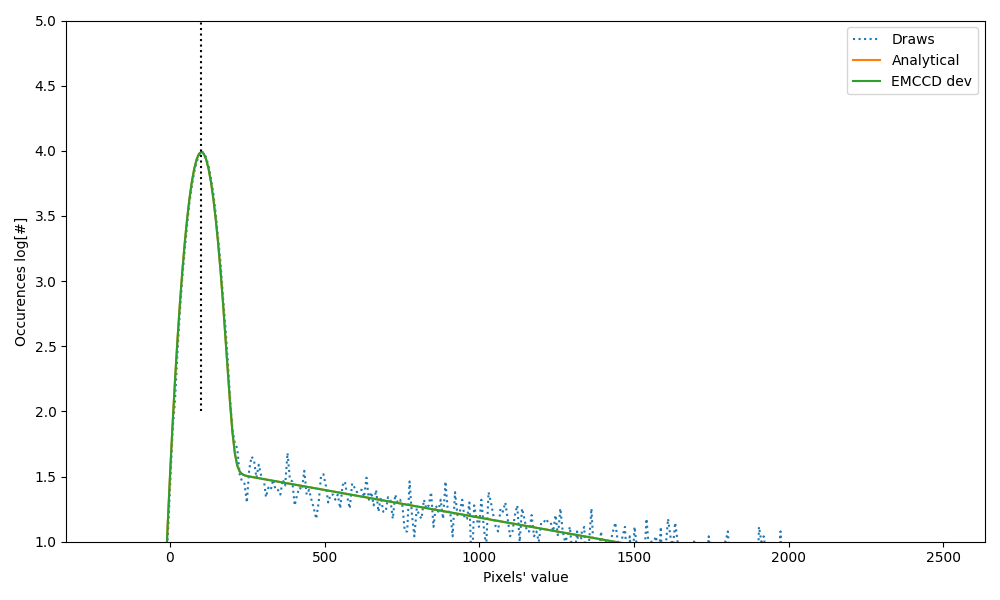

In [1]:
%matplotlib ipympl

import mpl_interactions.ipyplot as iplt
import matplotlib.pyplot as plt
import numpy as np
from astropy.convolution import Gaussian1DKernel, convolve
import scipy.special as sps
import numpy as np
from scipy.stats import poisson
from scipy.stats import poisson,gamma


n_pix = 10 ** 5
def simulate_emccd_image(
    ConversionGain,
    EmGain,
    Bias,
    RN,
    Smearing,
    SmearExpDecrement,
    flux,
    sCIC=0,
    n_registers=604,
):
    """Silumate EMCCD histogram
    flux = flux + dark + CIC 
    im = ConversionGain * gamma( poisson(np.nanmax([flux, 0]), abs(EmGain) )
    gamma( poisson(1 * id_scic), np.power(EmGain, np.random.randint(1, n_registers, size=id_scic.shape)  / n_registers)
    smearing(im) + normal(Bias, abs(RN * ConversionGain))

    """
    import numpy as np
    from scipy.sparse import dia_matrix

    # recover number of pixels to generate distributions

    n = 1
    # im = np.zeros(int(n_pix))  #
    im = np.zeros((1000, int(n_pix / 1000)))
    # print(flux)
    imaADU = np.random.gamma(np.random.poisson(np.nanmax([flux, 0]), size=im.shape), abs(EmGain))
    # changing total sCIC (e-) into the percentage of pixels experiencing spurious electrons
    # TODO maybe should be changed
    p_sCIC = (1-np.exp(-sCIC))#sCIC 
    # pixels in which sCIC electron might appear
    id_scic = np.random.rand(im.shape[0], im.shape[1]) < p_sCIC
    # stage of the EM register at which each sCIC e- appear
    register = np.random.randint(1, n_registers, size=id_scic.shape)
    # Compute and add the partial amplification for each sCIC pixel
    # when f=1e- gamma is equivalent to expoential law
    # should we add poisson here?
    imaADU += np.random.gamma(np.random.poisson(1 * id_scic), np.power(EmGain, register / n_registers))
    # imaADU += np.random.gamma(1 * id_scic, np.power(EmGain, register / n_registers))
    # imaADU[id_scic] += np.random.gamma(1, np.power(EmGain, register / n_registers))
    imaADU *= ConversionGain
    # smearing data
    def variable_smearing_kernels(
        image, Smearing=0.7, SmearExpDecrement=50000/2, type_="exp"
    ):
        """Creates variable smearing kernels for convolution or inversion
        """
        import numpy as np
        n = 30
        smearing_length = Smearing * np.exp(-image / SmearExpDecrement)
        if type_ == "exp":
            smearing_kernels = np.exp(
                -np.arange(n)[:, np.newaxis, np.newaxis] / smearing_length
            )
        else:
            assert 0 <= Smearing <= 1
            smearing_kernels = np.power(Smearing, np.arange(n))[
                :, np.newaxis, np.newaxis
            ] / np.ones(smearing_length.shape)
        smearing_kernels /= smearing_kernels.sum(axis=0)
        return smearing_kernels

    if Smearing > 0:
        n=30
        # smearing_kernels = np.exp(-np.arange(n)[:, np.newaxis, np.newaxis] / Smearing)
        # smearing_kernels /= smearing_kernels.sum(axis=0)
        smearing_kernels = variable_smearing_kernels(
            imaADU, Smearing, SmearExpDecrement
        )
        n_smearing = smearing_kernels.shape[0]
        offsets = np.arange(n_smearing)
        A = dia_matrix(
            (smearing_kernels.reshape((n_smearing, -1)), offsets),
            shape=(imaADU.size, imaADU.size),
        )
        imaADU = A.dot(imaADU.ravel()).reshape(imaADU.shape)
    # adding read noise and bias
    read_noise = np.random.normal(0, abs(RN * ConversionGain), size=im.shape)
    imaADU += Bias
    imaADU += read_noise
    return imaADU




def EMCCDhist(
    x,
    bias=[1e3, 4.5e3, 1194],
    RN=[0, 350, 53],
    EmGain=[100, 10000, 5000],
    flux=[0.0001, 1, 0.04],
    smearing=[0, 1.8, 0.01],
    sCIC=[0, 1, 0],
):
    """
    Stochastic model for EMCCD histogram.
    RN : Read noise in e-/pix
    EmGain : amplificaiton gain in e-/e-
    flux : incoming charges in e-/pix
    smearing : exponential length in pixel of the charge decay due to poor CTE
    sCIC : fraction of semi-amplified spurious charges that appear in the amplifier register
    """
    # def EMCCDhist(x, bias=[1e3, 4.5e3,1194], RN=[0,200,53], EmGain=[100, 10000,5000], flux=[0.001, 1,0.04], smearing=[0, 3,0.31], sCIC=[0,1,0],SmearExpDecrement=[1.5e3,1.5e5,15e4]):
    from scipy.sparse import dia_matrix
    import inspect
    from astropy.table import Table
    # from matplotlib.widgets import Button
    import numpy as np

    # if bias > 1500:
    #     ConversionGain = 0.53  # 1/4.5 #ADU/e-  0.53 in 2018
    # else:
    #     ConversionGain = 1 / 4.5  # ADU/e-  0.53 in 2018
    ConversionGain = 1  # /4.5


    # print("flux=",flux,"Smearing=", smearing)
    imaADU = simulate_emccd_image(
        ConversionGain=ConversionGain, 
        EmGain=EmGain,
        Bias=bias,
        RN=RN,
        Smearing=smearing,
        SmearExpDecrement=1e10,  # 1e4,  # 1e5 #2022=1e5, 2018=1e4...
        n_registers=604,
        flux=flux,
        sCIC=sCIC,
    )

    range = [np.nanmin(x), np.nanmax(x)]
    y, bins = np.histogram(imaADU.flatten(), bins=[x[0] - 1] + list(x))


    y[y == 0] = 1.0
    # y = y / (x[1] - x[0])
    # y = y / (bins[1] - bins[0])
    # print(np.nansum(y))
    return np.log10(y)



def EMCCD_no_smearing(x,bias,RN,EmGain,flux,sCIC):
    """EMCCD model based on convolution of distributions: Gamma(poison)xNormal
    First attempt to add smearing
    RN : Read noise in e-/pix
    EmGain : amplificaiton gain in e-/e-
    flux : incoming charges in e-/pix
    smearing : exponential length in pixel of the charge decay due to poor CTE
    sCIC : fraction of semi-amplified spurious charges that appear in the amplifier register
    """
    n_registers = 604  # number of amplification registers
    ConversionGain = 1 
    bin_size = np.median((x[1:] - x[:-1]))
    bins = x - np.nanmin(x)
    distributions = []
    pixs_sup_0 = 0  # fraction of pixels that have ADU higher than distribution limit
    # for smearing we consider each pixel recieve x% of their flux and Then
    # they receive the rest with a lower gain. This approximation is # NOTE:
    # true and need to be revised. The interest is that it is then independant
    # draws and that distributions can be convoluted.
    # for i, (flux_, EmGain) in enumerate(zip(fluxes, emgains)):
    gamma_distribution = 0
    # We sum up distributions from from the different poisson output
    for f in np.arange(1, 20):  
        # careful about the 20 limit which needs to be enough at high flux
        v = poisson.pmf(k=f, mu=np.nanmax([flux, 0]))
        # gamma distribution : https://numpy.org/doc/stable/reference/random/generated/numpy.random.gamma.html
        denominator = sps.gamma(f) * (EmGain * ConversionGain) ** f
        # print("denominator",denominator)
        distribution = (bin_size* bins ** (f - 1)* (np.exp(-bins / (EmGain * ConversionGain)) / denominator))
        # print("distribution",distribution)
        distribution_up = (3* bin_size* (3 * bins + bins.ptp()) ** (f - 1)* (    np.exp(-(3 * bins + bins.ptp()) / (EmGain * ConversionGain))    / denominator))
        # disminush the number of pixels by the fraction above distribution range
        if  (np.sum(distribution_up[np.isfinite(distribution_up)])  + np.sum(distribution[np.isfinite(distribution)])  )>0:
            factor = np.sum(distribution[np.isfinite(distribution_up)]) / (np.sum(distribution_up[np.isfinite(distribution_up)])  + np.sum(distribution[np.isfinite(distribution)])  )
        else:
            facor=0
        gamma_distribution += distribution * v
        pixs_sup_0 += (1 - factor) * v
    gamma_distribution[0] = (
        1
        - np.nansum(gamma_distribution[1:][np.isfinite(gamma_distribution[1:])])
        - pixs_sup_0
    )
    # adding sCIC and comvolving distributions as independant draws.
    # if sCIC > 0:
    #     # changing total sCIC (e-) into the percentage of pixels experiencing spurious electrons
    #     p_sCIC = sCIC  # / np.mean(1 / np.power(EmGain * ConversionGain, np.arange(604) / 604))
    #     # Estimation of average gain for semi-amplified CIC
    #     gain_ = np.power(EmGain * ConversionGain, np.linspace(1, n_registers, 100) / n_registers)
    #     cic_disdribution = np.sum([(1 / gaini) * np.exp(-bins / gaini) for gaini in gain_], axis=0)  # *n_pix/len(gain_)
    #     cic_disdribution /= cic_disdribution.sum()
    #     cic_disdribution *= p_sCIC
    #     cic_disdribution[0] = 1 - np.sum(cic_disdribution[1:])
    #     cic_disdribution = np.hstack((np.zeros(len(cic_disdribution) - 1), cic_disdribution))
    #     gamma_distribution = np.convolve(gamma_distribution, cic_disdribution, mode="valid")
    # distributions.append(gamma_distribution)

    if sCIC>0:
        gain_ = np.power(EmGain  * 1.41 , np.linspace(1, n_registers, 100) / n_registers)
        cic_disdribution = np.sum([(1 / gaini) * np.exp(-bins / gaini) for gaini in gain_], axis=0)  # *n_pix/len(gain_)
        cic_disdribution *= 1.3*np.exp(-flux)*(1-np.exp(-sCIC)) / cic_disdribution.sum()
        gamma_distribution[1:]  += cic_disdribution[1:]
        gamma_distribution[0] -= np.sum(cic_disdribution[1:]) 


    # Addition of the bias
    if (bias > x[0]) & (bias!=0):
        gamma_distribution[(x > bias)] = gamma_distribution[: -np.sum(x <= bias)]
        gamma_distribution[x < bias] = 0
    read_noise = Gaussian1DKernel(
        stddev=RN * ConversionGain / bin_size, x_size=int(301.1 * 10)
    )
    # Convolution with read noise
    if RN>0:
        y = convolve(gamma_distribution, read_noise) * n_pix  #
    else:
        y = gamma_distribution
    # y /= x[1] - x[0]
    # y[y<=0] =np.nan
    return y

    

def EMCCD_with_smearing(x,bias,RN,EmGain,flux,smearing,sCIC,):
    """EMCCD model based on convolution of distributions: Gamma(poison)xNormal
    First attempt to add smearing
    RN : Read noise in e-/pix
    EmGain : amplificaiton gain in e-/e-
    flux : incoming charges in e-/pix
    smearing : exponential length in pixel of the charge decay due to poor CTE
    sCIC : fraction of semi-amplified spurious charges that appear in the amplifier register
    """
    try:
        _, y, _ = np.loadtxt("/tmp/xy.txt").T
        # x, y =  np.array(x), np.array(y)
    except (OSError, ValueError) as e:
        try:
            _, y = np.loadtxt("/tmp/xy.txt").T

        except (OSError, ValueError) as e:
            _, y = np.array([0, 1]), np.array([0, 1])

    # recover number of pixels to generate distributions

    n_registers = 604  # number of amplification registers
    ConversionGain = 1 
    bin_size = np.median((x[1:] - x[:-1]))

    energy_fraction_kept = (1-np.exp(-flux/smearing)*(np.exp(-1/smearing)+np.exp(-2/smearing)+np.exp(-3/smearing))) if smearing>0 else 1
    gamma_distribution = EMCCD_no_smearing(x=x,bias=0,RN=0,EmGain=EmGain*energy_fraction_kept, flux=flux,sCIC=sCIC)

    if smearing>0. :
        for i in range(1,4):
            smeared_distri = EMCCD_no_smearing(x=x,bias=0,RN=0,EmGain=EmGain*np.exp(-i/smearing), flux=(1+np.exp(-i/smearing))*flux,sCIC=0)   * np.exp(-i*flux) #/smearing
            gamma_distribution[1:] +=  smeared_distri[1:]
            gamma_distribution[0] -= np.sum(smeared_distri[1:])


    # Addition of the bias
    if bias > x[0]:
        gamma_distribution[(x > bias)] = gamma_distribution[: -np.sum(x <= bias)]
        gamma_distribution[x < bias] = 0
    read_noise = Gaussian1DKernel(
        stddev=RN * ConversionGain / bin_size, x_size=int(301.1 * 10)
    )
    # Convolution with read noise
    y = convolve(gamma_distribution, read_noise) * n_pix  #
    # y /= x[1] - x[0]
    y[y<1]=1
    return np.log10(y)





def EMCCD_with_smearing2(
    x,
    bias,#=[x.min(), x.max(), x[np.argmax(y)]],
    RN,#=[5, 350, 12],
    EmGain,#=[10, 2000, 1900],
    flux,#=[0, 1, 0.01],
    smearing,#=[0, 3, 0.01],
    sCIC,#C=[0, 2, 0],
    test=True
):
    """EMCCD model based on convolution of distributions: Gamma(poison)xNormal
    First attempt to add smearing
    RN : Read noise in e-/pix
    EmGain : amplificaiton gain in e-/e-
    flux : incoming charges in e-/pix
    smearing : exponential length in pixel of the charge decay due to poor CTE
    sCIC : fraction of semi-amplified spurious charges that appear in the amplifier register
    """
    ConversionGain = 1 
    bin_size = np.median((x[1:] - x[:-1]))

    energy_fraction_kept = (1-np.exp(-flux/smearing)*(np.exp(-1/smearing)+np.exp(-2/smearing)+np.exp(-3/smearing))) if smearing>0 else 1
   
    gamma_distribution =  EMCCD_no_smearing(x=x,bias=0,RN=0,EmGain=EmGain*energy_fraction_kept, flux=flux,sCIC=sCIC)

    if (smearing>0.0)  :
        for i in range(1,4):
            smeared_distri = EMCCD_no_smearing(x=x,bias=0,RN=0,EmGain=EmGain*np.exp(-i/smearing), flux=flux,sCIC=0)   * np.exp(-i*flux) #/smearing
            gamma_distribution[1:] +=  smeared_distri[1:]
            gamma_distribution[0] -= np.sum(smeared_distri[1:])



    # Addition of the bias
    if bias > x[0]:
        gamma_distribution[(x > bias)] = gamma_distribution[: -np.sum(x <= bias)]
        gamma_distribution[x < bias] = 0
    read_noise = Gaussian1DKernel(
        stddev=RN * ConversionGain / bin_size, x_size=int(301.1 * 10)
    )
    # Convolution with read noise
    y = convolve(gamma_distribution, read_noise) * n_pix  #
    y[y<=0] = np.nan
    return np.log10(y)


x = np.linspace(-200,2500,350)
bias=100
fig, ax = plt.subplots(figsize=(10,6))
def EMCCD_dev_wo(x,bias,RN,EmGain,flux,smearing,sCIC,test=False):
    return EMCCD_dev(x,bias,RN,EmGain,flux,smearing,sCIC,test=test)
ylim=[1.,5]
controls = iplt.plot(x,  EMCCDhist, bias=bias, RN=np.linspace(30,100),EmGain=np.linspace(1000,2000),flux=np.linspace(0.05,0.8), smearing=np.linspace(0,1.2),sCIC=np.linspace(0,0.3),ls=":", ylim=ylim, label="Draws")
iplt.plot(x, EMCCD_with_smearing,controls=controls, ylim=ylim,label="Analytical")
iplt.plot(x, EMCCD_with_smearing2, "-", controls=controls, ylim=ylim, label="EMCCD dev")#,alpha=0.3)
_ = plt.legend()
plt.plot([bias,bias],[2,5],":k")
plt.legend()
plt.xlabel("Pixels' value")
plt.ylabel("Occurences log[#]")
fig.tight_layout()
plt.show()

